In [1]:
%%time 
%reload_ext autoreload
%autoreload 2
from utils.model import *
from utils.helpers import *
from utils.imports import *

# initialize some variables
list_num_tokens, list_losses, list_num_tokens_eval, list_losses_eval = [], [], [], {'train':[], 'val': []}


CUDA_VISIBLE_DEVICES = 7
device: cuda
CPU times: user 749 ms, sys: 171 ms, total: 919 ms
Wall time: 1.11 s


In [2]:
%%time
model, optimizer = load_train_objs(vocab_size, device, learning_rate)
val_data, val_urls = load_val_data(num_pages=10)


num_params: 10M
d_model: 384
n_layer: 6
n_heads:  6
d_head:  64
block_size:  128
batch_size: 64
learning_rate:  0.0003

CPU times: user 18.4 s, sys: 2.6 s, total: 21 s
Wall time: 9.41 s


In [3]:
# # train loop
# train(model, optimizer, device, batch_size, block_size, xb, yb, num_chars, val_data, 
#       list_epochs, list_losses, list_epochs_eval, list_losses_eval, eval_num_samples)


crawl_wiki_data: add=2.50M characters... 23908 new pages crawled (...Runtime: 1 min  3 sec), num_chars:2.56M
step:120  loss:0.506   (...Runtime: 1 min 17 sec)
 ==> get_batch: procured_batches = 6 out of 64 requested
 ==> get_batch: procured_batches = 6 out of 64 requested
train_loss:5.2904, val_loss:5.4063  (...Runtime: 0 min  1 sec)


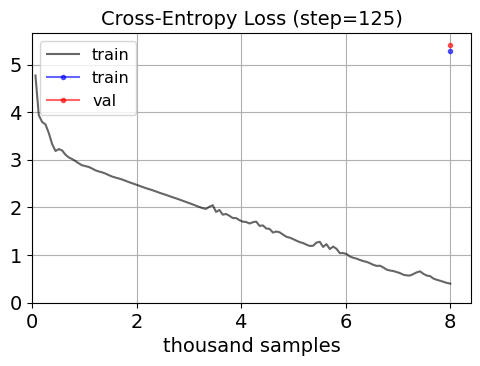

step:240  loss:0.015   (...Runtime: 1 min 32 sec)
 ==> get_batch: procured_batches = 6 out of 64 requested
 ==> get_batch: procured_batches = 6 out of 64 requested
train_loss:9.9040, val_loss:10.1412  (...Runtime: 0 min  1 sec)


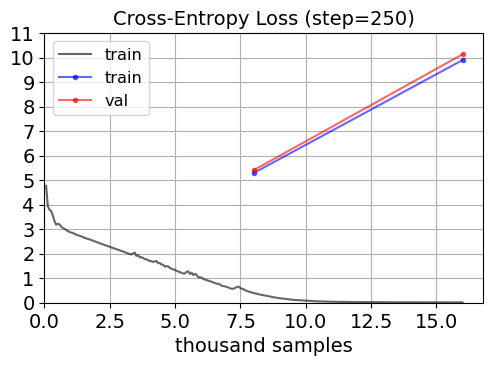

step:370  loss:0.012   (...Runtime: 1 min 48 sec)
 ==> get_batch: procured_batches = 6 out of 64 requested
 ==> get_batch: procured_batches = 6 out of 64 requested
train_loss:11.0293, val_loss:11.2875  (...Runtime: 0 min  1 sec)


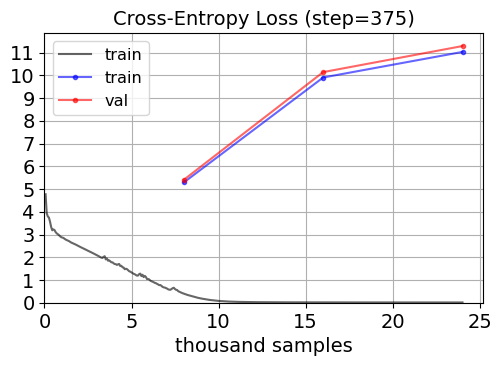

step:490  loss:0.011   (...Runtime: 2 min  3 sec)
 ==> get_batch: procured_batches = 6 out of 64 requested
 ==> get_batch: procured_batches = 6 out of 64 requested
train_loss:11.6997, val_loss:11.9698  (...Runtime: 0 min  1 sec)


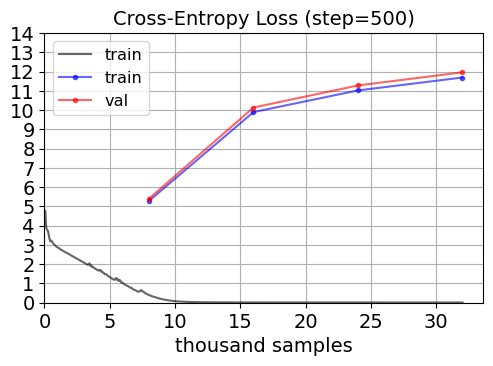

KeyboardInterrupt: 

In [4]:
start = time.time()
step = 0
train_data, num_chars = crawl_wiki_data(new_links, visited_urls, num_chars, add, printer=False)
xb, yb, pivot = get_batch(train_data, batch_size, pivot=0)

while step < max_iters:
    step += 1
    num_tokens = step * batch_size * block_size  #  num of tokens ingested.
    sample_no = step * batch_size * torch.cuda.device_count()

    while len(xb) < batch_size:
        repo_xb, repo_yb, pivot = xb, yb, 0
        train_data, num_chars = crawl_wiki_data(new_links, visited_urls, num_chars, add, printer=False)

        # Sample a batch of data to complete to the "batch_size"
        xb, yb, pivot = get_batch(train_data, batch_size - len(xb), pivot)
        xb = torch.cat((repo_xb, xb))
        yb = torch.cat((repo_yb, yb))

    # Evaluate the loss
    logits, loss = model(xb, yb)
    
    # Average if trained on multi-GPUs 
    loss = loss.mean()
    
    optimizer.zero_grad(set_to_none=True)
    loss.backward() # get the gradients with backprop.
    optimizer.step() # apply the gradient on the parameters

    list_losses.append(loss.item())
    list_num_tokens.append(sample_no)

    # evaluate at fixed intervals
    if sample_no % (eval_num_samples // 4) == 0:
        list_num_tokens_eval.append(sample_no)
        out = estimate_loss(model, train_data[-len(val_data):], val_data, step, start)
        list_losses_eval['val'].append(out['val'])
        list_losses_eval['train'].append(out['train'])
        plotter(list_num_tokens, list_losses, list_num_tokens_eval, list_losses_eval)

    if sample_no % (eval_num_samples * 4) == 0:
        generate_text(model, step)

    if step % 10 == 0: 
        print(f'step:{step:3d}  loss:{loss.item():.3f}  {print_runtime(start, False)}', end='\r')


---

# todo 
- make sure we're comnputing loss in  `estimate_loss` correctly, in terms of `np.mean(loss.tolist())` etc
- in `estimate_loss` how is train_loss computed. 
- in `estimate_loss` add list_losses as a dict with `'val'` and `'train'` as keys
- Check if we're doing DDP across 8 GPUs correctly.
- check if `batch_size` designates number of batches per each GPU or the total batches of 8 GPUs.
- ~`get_batches` should get partial batches if it runs out of sentences~
- `get_batches` should process one wiki page at a time. 
- Use `tiktoken` tokenizer


# The Mathematical Trick in Self-Attention

- Attention is a **communication mechanism**. It's anodes in a graph looking at each other and aggregating informtaion with a weighted sum from all nodes pointing to them  

- No notion of space. Attention itself only acts over nodes and vectors.

- Separate batches don't talk to each other. Each example across batch dimension is processed independently. 

- **Encoder:**  No masking with `tril` allowing all tokens to communicate. **Decoder** uses masking in an autoregressive settings so past tokens don't talk to future tokens --otherwise they would give away the answer.

- **Self-Attention:** keys, queries and values arecome from the same source. 
- **Cross-Attention:** queries are produced from x, keys and values are produced from a previous encoder module. Encoder encodes some context we want the decoder's generation process to be conditioned on.
- **Scaling by sqrt(d):** It's an important normalization to have. 


----
## 1. Experiments

device: cuda


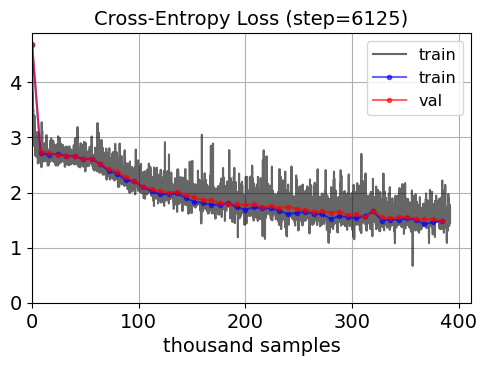

step:6125   (...Runtime: 260 min 17 sec)
===>  Text Generation: 
Aayi). Alfter Guyle, the normation is not that Bozs, and not direct developned by the season Brosston and Adelka, Riman and Shahan's has headed, the restluct of his texts section, 2012, following that he was spoken for the pin somebombassywhat the text Buddha. There the best of Keahan (unities by the comApplication pin't foundation of he was premiered as a superindumber of the Sha'd; a like texts o
Runtime: 0 min 17 sec
------------------------------------------------------------------------------------------


In [26]:
plotter(list_epochs, list_losses, list_epochs_eval, list_losses_eval, step)
print(f'step:{step:3d}  {print_runtime(start, False)}')
# model.print_hyperparams_to_stdout()
generate_text(model, step, time.time())


## 2. Experiments
---

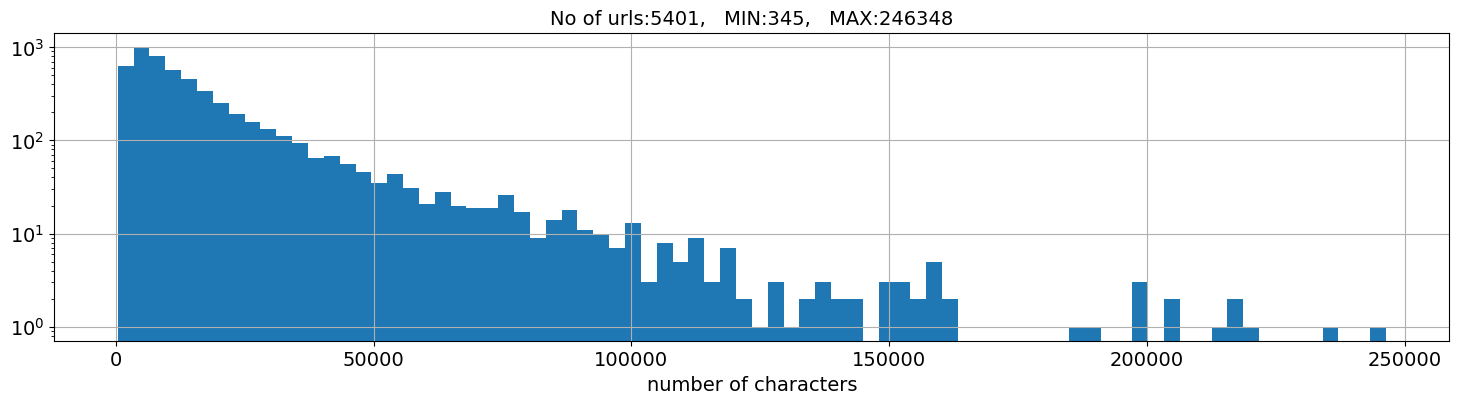

In [2]:
dirname='dataset/repo_wiki/'
fnames = sorted(glob.glob(f'{dirname}/*pkl'))
wikis = dict()
for fname in fnames:
    with open(fname, 'rb') as f:
        wikis.update(pickle.load(f)) 

urls = list(wikis.keys())
out = [(len(wikis[url])) for url in (urls)]
x, y, patches  = plt.hist(out, bins=80, log=True); plt.xlabel('number of characters'); 
plt.title(f'No of urls:{len(urls)},   MIN:{min(out)},   MAX:{max(out)}');


/data/home/osafak/.conda/envs/pt_env/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/data/home/osafak/.conda/envs/pt_env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


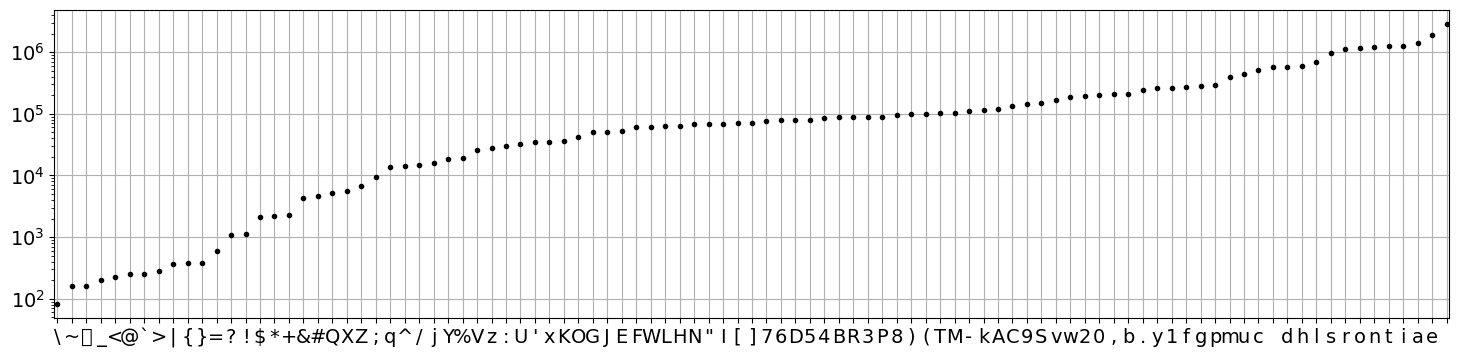

In [3]:
cnt = plot_character_frequency(urls[:1000], wikis)